# Problem 2

In [1]:
from __future__ import print_function
import time
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F

In [3]:
import torchvision
import torchvision.transforms

In [4]:
import matplotlib.pyplot as plt

In [5]:
mnist_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=mnist_transforms, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=mnist_transforms, download=True)

Processing...
Done!


In [6]:
(mnist_train[0][0][0]).shape

torch.Size([28, 28])

In [7]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True, num_workers=2)

In [8]:
class Classifier(nn.Module):
    """Convnet Classifier"""
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.8),
            nn.ReLU(),
            
            # Layer 2
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=96, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=128, out_channels=192, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 5
            nn.Conv2d(in_channels=192, out_channels=256, kernel_size=(3,3), padding=1),
            nn.Dropout(p=0.8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2)
        )
        # Logistic Regression
        self.clf = nn.Linear(256, 10)

    def forward(self, x):
        return self.clf(self.conv(x).squeeze())


In [9]:
cuda_available = torch.cuda.is_available()
print(cuda_available)

True


In [16]:
clf = Classifier()
if cuda_available:
    clf = clf.cuda()
optimizer = torch.optim.Adam(clf.parameters(), lr=5e-4)
scheduler_ = torch.optim.lr_scheduler.MultiStepLR(optimizer, [6,8], gamma=0.8)
criterion = nn.CrossEntropyLoss()
# This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.

Epoch : 0 Test Acc : 91.000
--------------------------------------------------------------
Epoch : 1 Test Acc : 96.000
--------------------------------------------------------------
Epoch : 2 Test Acc : 97.000
--------------------------------------------------------------
Epoch : 3 Test Acc : 98.000
--------------------------------------------------------------
Epoch : 4 Test Acc : 98.000
--------------------------------------------------------------
Epoch : 5 Test Acc : 98.000
--------------------------------------------------------------
Epoch : 6 Test Acc : 98.000
--------------------------------------------------------------
Epoch : 7 Test Acc : 98.000
--------------------------------------------------------------
Epoch : 8 Test Acc : 98.000
--------------------------------------------------------------
Epoch : 9 Test Acc : 98.000
--------------------------------------------------------------


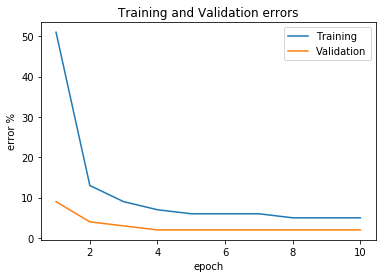

In [17]:
dict_err = {}
dict_err["tr"] = []
dict_err["val"] = []

for epoch in range(10):
    losses = []
    total = 0
    correct = 0
    # Train
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        # scheduler_.step()
        optimizer.zero_grad()
        outputs = clf(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.data.item())
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        
        
#         if batch_idx%50==0:
#             print('Epoch : %d Loss : %.3f ' % (epoch, np.mean(losses)))
    dict_err["tr"].append(100. - 100.*correct/total)
    
    # Evaluate
    clf.eval()
    total = 0
    correct = 0
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        outputs = clf(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    
    dict_err["val"].append(100. - 100.*correct/total)

    
    print('Epoch : %d Test Acc : %.3f' % (epoch, 100.*correct/total))
    print('--------------------------------------------------------------')
    clf.train()

    x = np.arange(1,len(dict_err["tr"])+1,1)
    fig = plt.figure(1)
    fig.clear()
    plt.title("Training and Validation errors")
    plt.plot(x, dict_err["tr"], label="Training")
    plt.plot(x, dict_err["val"], label="Validation")
    plt.xlabel("epoch")
    plt.ylabel("error %")
    plt.legend()
    
#     if (epoch != 9):
#         plt.close()
